In [1]:
import numpy as np
import pandas as pd
import cv2
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.models import load_model
from keras.applications.vgg16 import VGG16 #For Transfer Learning
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
data = pd.read_csv('../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv')

In [3]:
data

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
...,...,...,...,...,...,...
12441,12441,Cyst- (2522),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12442,12442,Cyst- (2627),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12443,12443,Cyst- (972),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12444,12444,Cyst- (2323),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12446 entries, 0 to 12445
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12446 non-null  int64 
 1   image_id    12446 non-null  object
 2   path        12446 non-null  object
 3   diag        12446 non-null  object
 4   target      12446 non-null  int64 
 5   Class       12446 non-null  object
dtypes: int64(2), object(4)
memory usage: 583.5+ KB


In [5]:
data['Class'].unique()

array(['Tumor', 'Normal', 'Stone', 'Cyst'], dtype=object)

In [6]:
kidney_classes = data['Class'].value_counts()
kidney_classes

Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: Class, dtype: int64

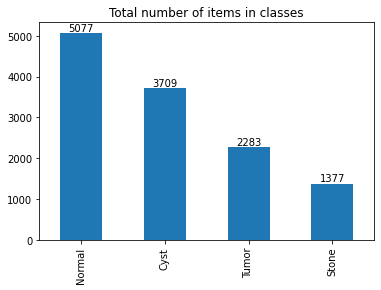

In [7]:
plot_bar = kidney_classes.plot.bar(title='Total number of items in classes')
plot_bar.bar_label(plot_bar.containers[0]);

In [8]:
pip install split_folders

Note: you may need to restart the kernel to use updated packages.


In [9]:
import splitfolders
splitfolders.ratio("../input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone", output="dataset", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 12446 files [01:22, 150.22 files/s]


In [10]:
channels=3
batch_size=25
test_batch_size=32 
test_steps=1
train_path = './dataset/train'
test_path = './dataset/test'
val_path = './dataset/val'

def scalar(img):    
    return img  # EfficientNet expects pixelsin range 0 to 255 so no scaling is required

train_gen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
test_gen=ImageDataGenerator(preprocessing_function=scalar)
train_generator=train_gen.flow_from_directory( directory=train_path , target_size=(224,224), class_mode='categorical',
                                     shuffle=True, batch_size=batch_size)
test_generator=test_gen.flow_from_directory( directory=test_path, target_size=(224,224), class_mode='categorical',
                                     shuffle=False, batch_size=test_batch_size)

valid_generator=test_gen.flow_from_directory( directory=val_path, target_size=(224,224), class_mode='categorical',
                                     shuffle=True, batch_size=batch_size)
classes=list(train_generator.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_generator.labels)/batch_size))

Found 9955 images belonging to 4 classes.
Found 1249 images belonging to 4 classes.
Found 1242 images belonging to 4 classes.


In [11]:
base_model = VGG16(include_top = False, input_shape = (224,224,3), classes = 38)
model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

2022-05-10 16:40:12.119633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 16:40:12.221098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 16:40:12.221899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 16:40:12.223242: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 1s 0us/step


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
model.add(Dense(4,activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [14]:
batch_size= 1218
epochs=15
learn_rate=.001
sgd=SGD(learning_rate=learn_rate,momentum=.9,nesterov=False)
adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
history = model.fit(train_generator,epochs = 10, validation_data = valid_generator, verbose = 1)

2022-05-10 16:40:19.237803: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-05-10 16:40:20.993296: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


399/399 [==============================] - 111s 252ms/step - loss: 1.0724 - accuracy: 0.5508 - val_loss: 0.8433 - val_accuracy: 0.6618
Epoch 2/10
399/399 [==============================] - 97s 243ms/step - loss: 0.4596 - accuracy: 0.8288 - val_loss: 0.2242 - val_accuracy: 0.9219
Epoch 3/10
399/399 [==============================] - 96s 241ms/step - loss: 0.1800 - accuracy: 0.9368 - val_loss: 0.0506 - val_accuracy: 0.9831
Epoch 4/10
399/399 [==============================] - 97s 243ms/step - loss: 0.0992 - accuracy: 0.9648 - val_loss: 0.0966 - val_accuracy: 0.9638
Epoch 5/10
399/399 [==============================] - 99s 247ms/step - loss: 0.0631 - accuracy: 0.9788 - val_loss: 0.0313 - val_accuracy: 0.9895
Epoch 6/10
399/399 [==============================] - 97s 242ms/step - loss: 0.0294 - accuracy: 0.9921 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 7/10
399/399 [==============================] - 97s 243ms/step - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0118 - val_accuracy: 0.

In [16]:
def print_info( test_gen, preds, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
#     if errors>0:
#         plot_bar=[]
#         plot_class=[]
#         for  key, value in new_dict.items():        
#             count=error_indices.count(key) 
#             if count!=0:
#                 plot_bar.append(count) # list containg how many times a class c had an error
#                 plot_class.append(value)   # stores the class 
#         fig=plt.figure()
#         fig.set_figheight(len(plot_class)/3)
#         fig.set_figwidth(10)
#         plt.style.use('fivethirtyeight')
#         for i in range(0, len(plot_class)):
#             c=plot_class[i]
#             x=plot_bar[i]
#             plt.barh(c, x, )
#             plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 40:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

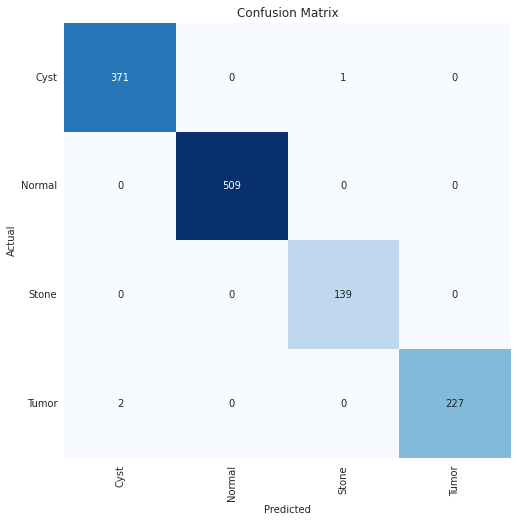

Classification Report:
----------------------
               precision    recall  f1-score   support

        Cyst       0.99      1.00      1.00       372
      Normal       1.00      1.00      1.00       509
       Stone       0.99      1.00      1.00       139
       Tumor       1.00      0.99      1.00       229

    accuracy                           1.00      1249
   macro avg       1.00      1.00      1.00      1249
weighted avg       1.00      1.00      1.00      1249



In [17]:
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
p = model.predict(test_generator)
print_info( test_generator, p, r'./', 'kidney')  

In [18]:
model.evaluate(test_generator)

40/40 [==============================] - 9s 225ms/step - loss: 0.0099 - accuracy: 0.9976


[0.009943887591362, 0.9975980520248413]

In [19]:
model.save("vgg16.h5")

In [20]:
import shutil 
shutil.rmtree('./dataset')

In [21]:
history.params
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

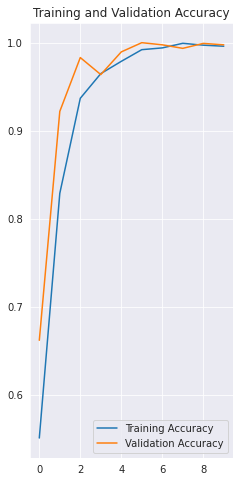

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

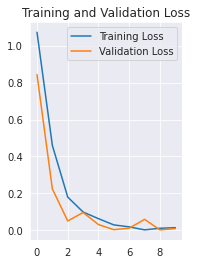

In [25]:
plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
path = input("Enter Image path: ")

StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread(path)

fig = plt.figure(figsize=(100,100))
 
# Use the cvtColor() function to grayscale the image
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
fig.add_subplot(1, 4, 1)
plt.imshow(gray_image,interpolation='nearest')
plt.axis('off')

img_median = cv2.medianBlur(gray_image, 5)

fig.add_subplot(1, 4, 2)
plt.imshow(img_median,interpolation='nearest')
plt.axis('off')
# equ = cv2.equalizeHist(img_median)

gamma_corrected = np.array(255*(img_median / 255) ** 2.5, dtype = 'uint8')

In [ ]:
fig.add_subplot(1, 4, 3)
plt.imshow(gamma_corrected,interpolation='nearest')
plt.axis('off')

ret, thresh1 = cv2.threshold(gamma_corrected, 120, 255, cv2.THRESH_BINARY)

fig.add_subplot(1, 4, 4)
plt.imshow(thresh1,interpolation='nearest')
plt.axis('off')